# Result data analyses from complex training
### Data fetched eitherlocally or from gdrive via oauth

In [1]:
# !rm -f *.png

## Compile Form in order to run the notebook

Forms provide an easy way to parameterize code. From a code cell, select Insert → Add form field. When you change the value in a form, the corresponding value in the code will change.

In [2]:
#@title Compile this form to run notebook:
import os
import warnings
warnings.filterwarnings("ignore", message="Numerical issues were encountered ")

#@markdown ---
#@markdown ##### Enter Root path:
root_path = "." # @param [".", /content/", "/content/drive/My Drive/Siren Deep Learning Analyses/results"]

#@markdown ---
#@markdown ##### Enter trial number:
train_no =  0  #@param {type:"integer", min:0, max:23, step:1}

#@markdown ---
#@markdown ##### Toggle checkbox to download resulting pictures:
download_pictures_checkbox = False #@param {type:"boolean"}

#@markdown ---
#@markdown ##### Toggle checkbox to download old files, related to old analyses:
delete_old_files_checkbox = False #@param {type:"boolean"} # TODO: not yet employed.

fetch_data_from_gdrive_checkbox = True #@param {type:"boolean"}

#@markdown ---
#@markdown ##### Enter dirname and image name:
dir_image = "/content/drive/My Drive/Siren Deep Learning Analyses/testsets/BSD68" # @param ["/content/", "/content/drive/My Drive/Siren Deep Learning Analyses/testsets/BSD68"]
image_name = "test068.png" #@param {type:"string"}

#@markdown ---
#@markdown ##### Enter dirname for saving outputs:
basedir_path_out_images = f"mixed_out_train_{train_no}" # @oaram ["/content", ".", out_train_{train_no}]

show_visdom_results = False

## Authentication phase

In [3]:
from utils.gdrive_auth import make_grdive_auth, fetch_data_from_gdrive

creds = make_grdive_auth()

Gdrive auth done.


## Setup

### Installations

In [4]:
#hide
# !pip install -q visdom
# !pip install -q gwpy
# !pip install -U git+git://github.com/fastai/fastcore@master
# !pip install -U git+git://github.com/fastai/nbdev@master

In [5]:
# Clean /content from trash or old .png images
# !rm -f /content/*.png

In [6]:
from fastcore.foundation import *
from fastcore.meta import *
from fastcore.utils import *
from fastcore.test import *
from nbdev.showdoc import *
from fastcore.dispatch import typedispatch
from functools import partial
import inspect

from fastcore.imports import in_notebook, in_colab, in_ipython

### Imports

In [7]:
from datetime import datetime
if in_colab():
    from google.colab import files

from pathlib import Path
from collections import namedtuple
from operator import methodcaller
from io import BytesIO
from pprint import pprint

# import psycopg2 as ps
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
# sns.set_theme(style="whitegrid")
import ipywidgets as widgets
# back end of ipywidgets
from IPython.display import display

import io
from googleapiclient.http import MediaIoBaseDownload
import zipfile

import collections
import itertools
import functools
import glob
import operator
import os
import re
import yaml
import numpy as np
import pandas as pd
import visdom

from PIL import Image

# skimage
import skimage
import skimage.metrics as skmetrics
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from utils.make_graphics import (compute_graph_image_psnr_CR, graphics_bars_pointplot, \
  graphics_scatterplot, graphics_violinplot, graphics_boxplot, graphics_bars_mean_std, \
  graphics_pointplot_mean_std, graphics_regplot_mean_std)

from utils.works import calculate_several_jpeg_compression, get_cropped_by_center_image
from utils.functions import get_dataframe_histories, get_path_histories

### Setup output images full path

In [8]:
# Create output directory where to store results.

try:
    os.makedirs(basedir_path_out_images)
    print(f'Directory {basedir_path_out_images} created.')
except:
    print(f'Directory {basedir_path_out_images} already exists!')
    pass

Directory mixed_out_train_0 already exists!


### Get configs

In [9]:
# Read config files.

from utils.configs import get_input_data_configs, get_output_graphics_configs

input_data_config = get_input_data_configs()

images_conf = get_output_graphics_configs(basedir_path_out_images)

config file read with success.
config file read with success.


### Functions

### Fetch Data

In [10]:
# Fetch data from Gdrive and store them where specified
# by means of history path.

path_history_trains = get_path_histories(root_path, input_data_config)

for path_history_train, file_id in zip(path_history_trains, input_data_config.file_ids):
    print('Trying fetching', path_history_train, '...')
    fetch_data_from_gdrive(creds, path_history_train, file_id, fetch_data_from_gdrive_checkbox)
    pass

Path location:
['.\\result_comb_train_19.txt']
Trying fetching .\result_comb_train_19.txt ...
Download 100%.


In [11]:
# Create dataframe containing data collected during training time.

columns_df = ['#params', 'seed', 'hl', 'hf', 'mse', 'psnr', 'ssim', 'train_eta']

results_history_df = get_dataframe_histories(
    path_history_trains = path_history_trains,
    columns = columns_df)

### Dataframe: brief description

In [12]:
results_history_df.head(5)

,#params,seed,hl,hf,mse,psnr,ssim,train_eta
0,21057.0,0.0,5.0,64.0,0.004190,26.895307,0.849100,760.433449
1,21057.0,42.0,5.0,64.0,0.004701,28.969262,0.841593,765.351714
2,21057.0,123.0,5.0,64.0,0.004415,28.283117,0.848052,756.820854
3,29377.0,0.0,7.0,64.0,0.003195,29.876833,0.828572,1001.351421
4,29377.0,42.0,7.0,64.0,0.003168,27.448205,0.856999,1012.941984


In [13]:
results_history_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   #params    20 non-null     float64
 1   seed       20 non-null     float64
 2   hl         20 non-null     float64
 3   hf         20 non-null     float64
 4   mse        20 non-null     float64
 5   psnr       20 non-null     float64
 6   ssim       20 non-null     float64
 7   train_eta  20 non-null     float64
dtypes: float64(8)
memory usage: 1.4 KB


In [14]:
results_history_df.describe()

,#params,seed,hl,hf,mse,psnr,ssim,train_eta
count,20.000000,20.000000,20.000000,20.0,20.000000,20.000000,20.000000,20.000000
mean,36449.000000,51.600000,8.700000,64.0,0.003237,28.145416,0.837285,1263.739454
std,9262.793486,51.232597,2.226633,0.0,0.000702,2.294420,0.018919,313.058011
min,21057.000000,0.000000,5.000000,64.0,0.002338,23.576168,0.796155,756.820854
25%,29377.000000,0.000000,7.000000,64.0,0.002652,26.880714,0.827886,1021.157870
50%,37697.000000,42.000000,9.000000,64.0,0.003181,28.626190,0.841574,1292.793969
75%,42897.000000,123.000000,10.250000,64.0,0.003389,30.217776,0.850986,1480.892380
max,50177.000000,123.000000,12.000000,64.0,0.004701,30.559127,0.865563,1742.564874


In [15]:
# Check which hidden features are within dataframe
# and count how many occurences for each hidden feature.

collections.Counter(results_history_df["hf"].values)

Counter({64.0: 20})

### Dataframe: in depth description

#### Scatter - Plot

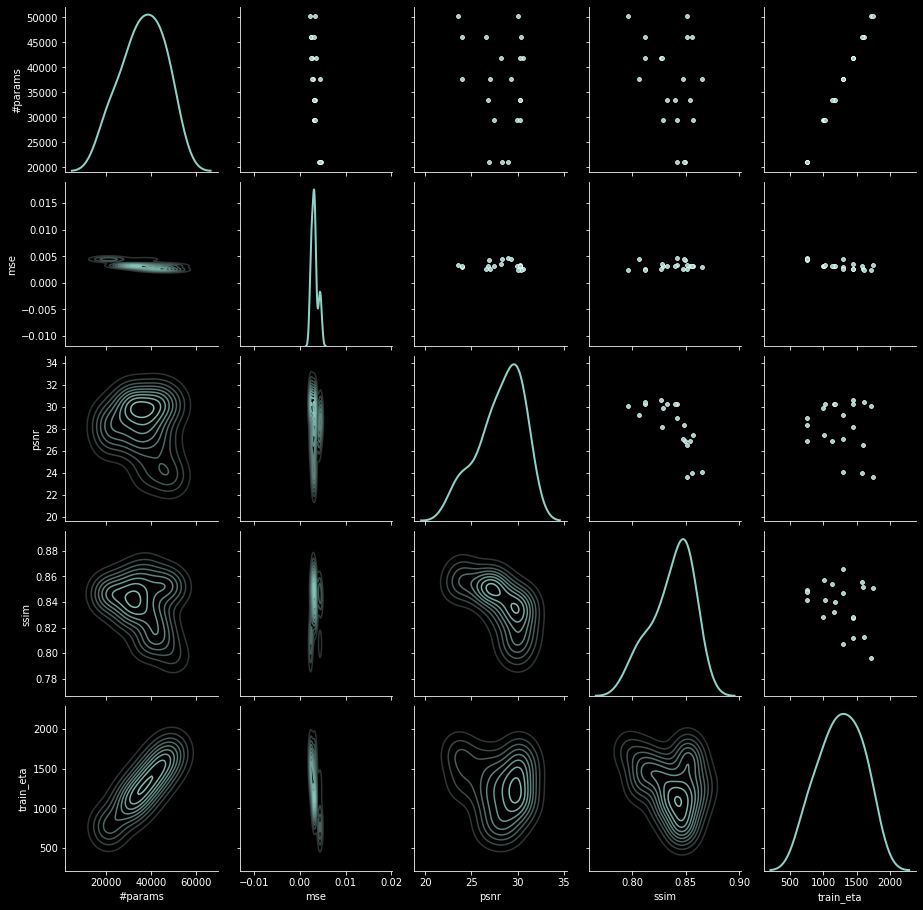

In [16]:
# Get the big picture, just to have an overall idea.

# sns.pairplot(results_history_df)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    try:
        g = sns.PairGrid(results_history_df.drop(['hf', 'hl', 'seed'], axis = 1), diag_sharey=False)
        g.map_upper(sns.scatterplot, s=15) # 
        g.map_lower(sns.kdeplot)
        g.map_diag(sns.kdeplot, lw=2)
        # plt.savefig(f'scatter_plot_train_no_{train_no}.png')
        plt.savefig(f'{images_conf.df_scatterplot}')
    except Exception as err:
        print(str(err))
        pass
    pass

#### Plots

In [17]:
# Compute Mean and Standard-Deviation for MSE and PSNR
# with respect to data grouped by means of'#params'-attribute
# within dataframe object: 'results_history_df

results_history_df.groupby(by = ['#params'])[['mse', 'psnr', 'ssim', 'train_eta']]\
    .describe()[[
                ("mse", "mean"), ("mse", "std"),
                ("psnr", "mean"), ("psnr", "std"),
                ("ssim", "mean"), ("ssim", "std"),
                ("train_eta", "mean"), ("train_eta", "std")
                ]]

mse                 psnr                ssim            \
             mean       std       mean       std      mean       std   
#params                                                                
21057.0  0.004436  0.000256  28.049229  1.056575  0.846248  0.004066   
29377.0  0.003242  0.000106  29.179998  1.509275  0.842375  0.014231   
33537.0  0.003168  0.000098  29.114726  1.972817  0.842171  0.011183   
37697.0  0.003329  0.000960  26.764128  2.624960  0.839884  0.030119   
41857.0  0.002854  0.000533  29.665793  1.305736  0.822329  0.009172   
46017.0  0.002687  0.000363  26.977452  3.227822  0.839887  0.023997   
50177.0  0.002796  0.000647  26.827166  4.597605  0.823504  0.038677   

           train_eta             
                mean        std  
#params                          
21057.0   760.868672   4.282051  
29377.0  1012.729968  11.274034  
33537.0  1157.602410  19.666485  
37697.0  1295.349837   4.660225  
41857.0  1443.508016   2.050389  
46017.0  1599.349842  16.921456  
50177.0  1733.281420  13.128786

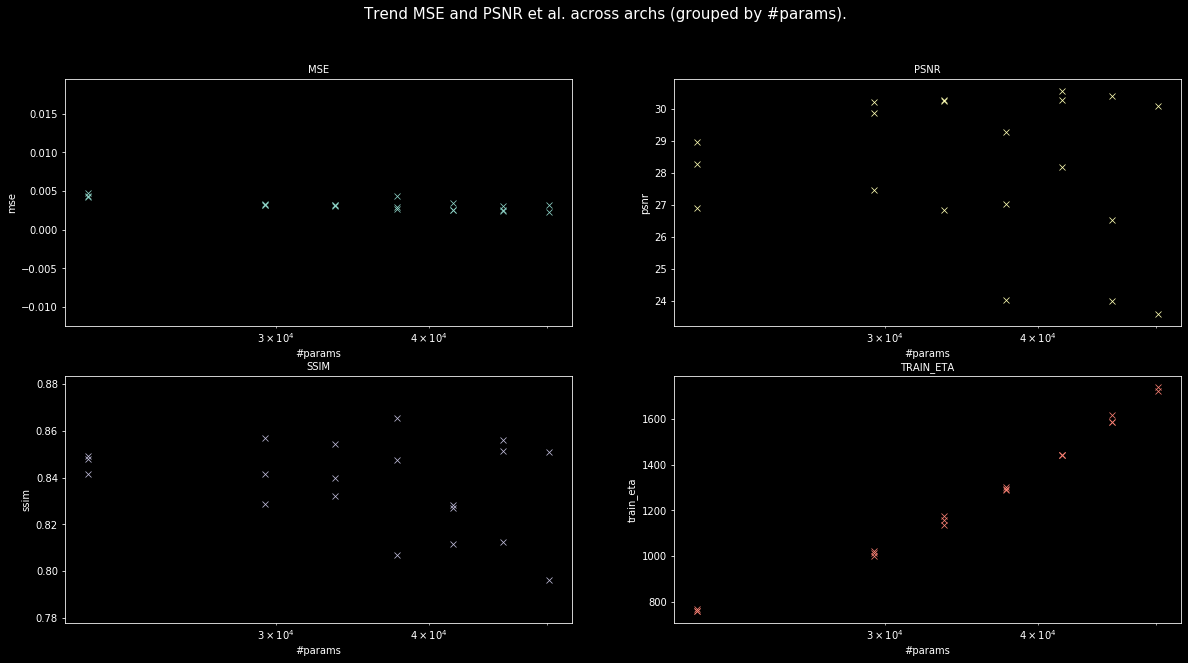

In [18]:
grid_shape = "(2, 2)" # @param ["(1, 4)", "(4, 1)", "(2, 2)"]
grid_shape = eval(grid_shape)

fig, axes = graphics_scatterplot(
    dataframe = results_history_df,
    y_axes = ("mse", "psnr", "ssim", "train_eta"),
    x_axis = "#params",
    grid_shape = grid_shape,
    figsize = (20, 10))
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"scatterplot_mse_psnr_et_al_vs_no_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.scatterplot}")

plt.show()

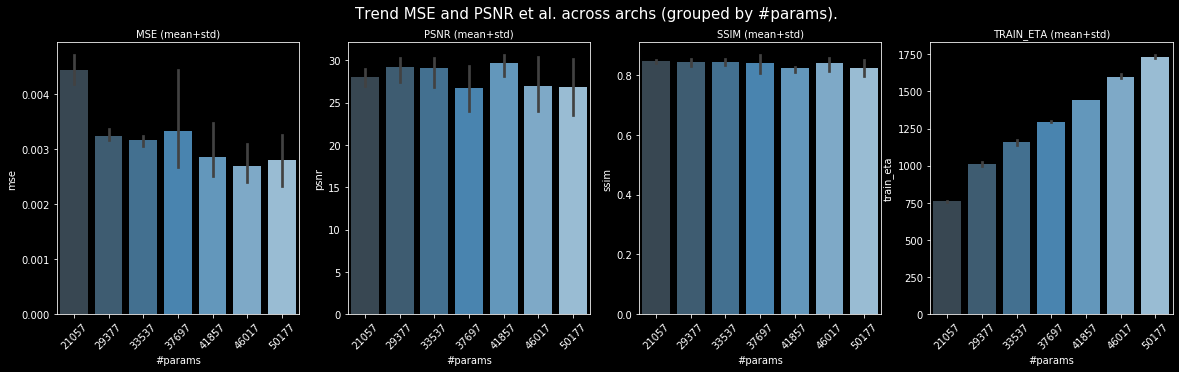

In [19]:
# %%capture
results_history_sorted_df = results_history_df.sort_values(by=['#params', 'hf', 'hl'])

grid_shape = "(1, 4)" #@param ["(1, 4)", "(4, 1)", "(2, 2)"]
grid_shape = eval(grid_shape)

fig, axes = graphics_bars_mean_std(
    dataframe = results_history_sorted_df,
    y_axes = ("mse", "psnr", "ssim", "train_eta"),
    x_axis = "#params",
    grid_shape = grid_shape,
    figsize = (20, 5))
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"bar_plot_mse_psnr_et_al_grouped_by_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.barplot}")
plt.show()

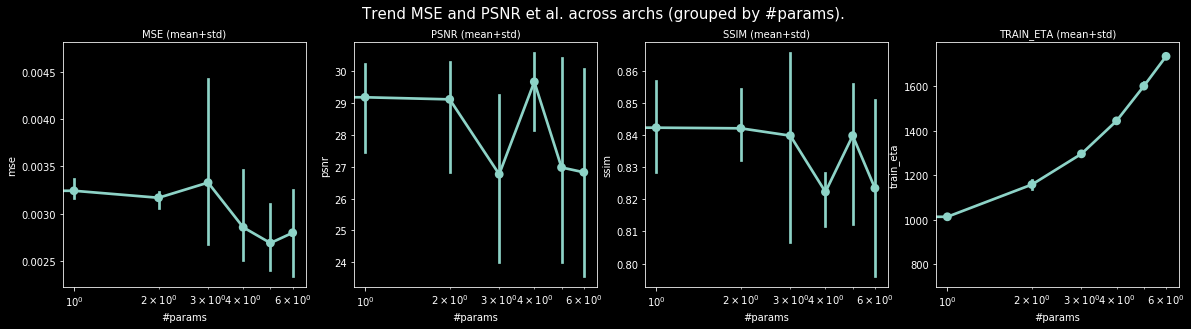

In [20]:
results_history_sorted_df = results_history_df.sort_values(by=['#params', 'hf', 'hl'])

grid_shape = "(1, 4)" #@para m ["(1, 4)", "(4, 1)", "(2, 2)"]
grid_shape = eval(grid_shape)

fig, axes = graphics_pointplot_mean_std(
    dataframe = results_history_sorted_df,
    y_axes = ("mse", "psnr", "ssim", "train_eta"),
    x_axis = "#params",
    grid_shape = grid_shape, 
    figsize = (20, 5))
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"pointplot_mse_psnr_et_al_grouped_by_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.pointplot}")
plt.subplots_adjust(bottom = 0.2)
plt.show()

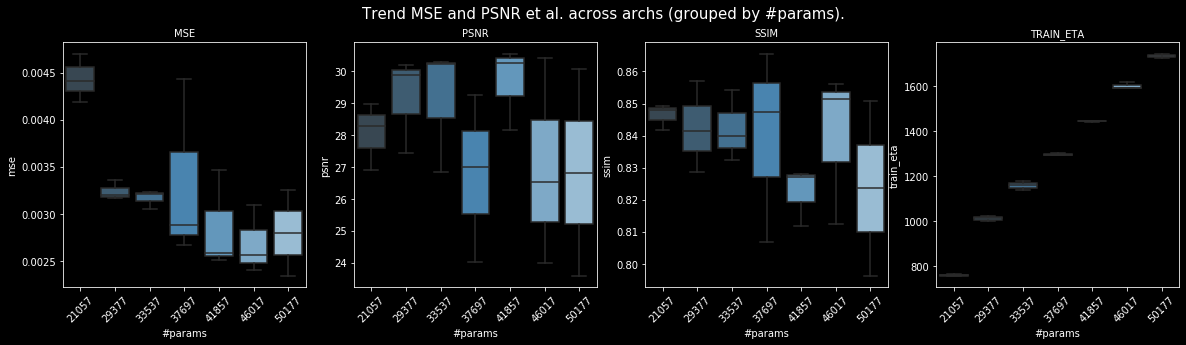

In [21]:
results_history_sorted_df = results_history_df.sort_values(by=['#params', 'hf', 'hl'])

grid_shape = "(1, 4)" #@param ["(1, 4)", "(4, 1)", "(2, 2)"]
grid_shape = eval(grid_shape)

fig, axes = graphics_boxplot(
    dataframe = results_history_sorted_df,
    y_axes = ("mse", "psnr", "ssim", "train_eta"),
    x_axis = "#params",
    grid_shape = grid_shape,
    figsize = (20, 5))
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"boxplot_mse_psnr_et_al_grouped_by_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.boxplot}")
plt.subplots_adjust(bottom = 0.2)
plt.show()

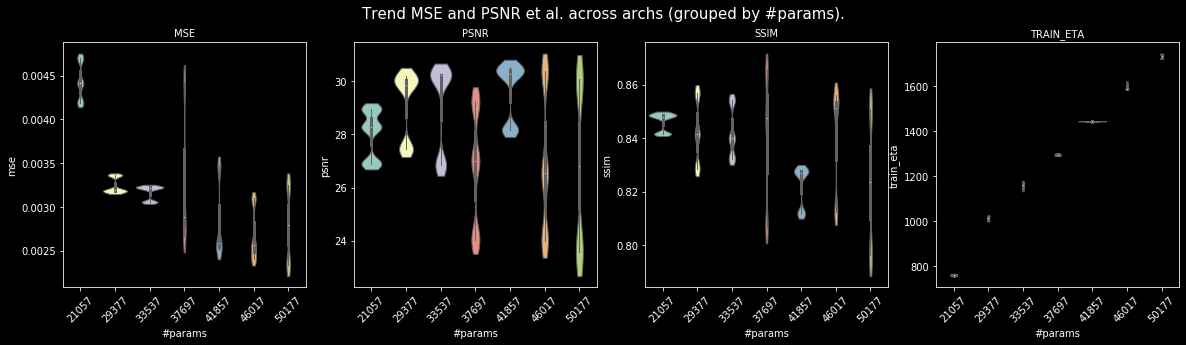

In [22]:
results_history_sorted_df = results_history_df.sort_values(by=['#params', 'hf', 'hl'])

grid_shape = "(1, 4)" #@param ["(1, 4)", "(4, 1)", "(2, 2)"]
grid_shape = eval(grid_shape)

fig, axes = None, None
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig, axes = graphics_violinplot(
        dataframe = results_history_sorted_df,
        y_axes = ("mse", "psnr", "ssim", "train_eta"),
        x_axis = "#params",
        grid_shape = grid_shape,
        figsize = (20, 5))
    pass
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"violinplot_mse_psnr_et_al_grouped_by_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.violinplot}")
plt.subplots_adjust(bottom = 0.2)
plt.show()

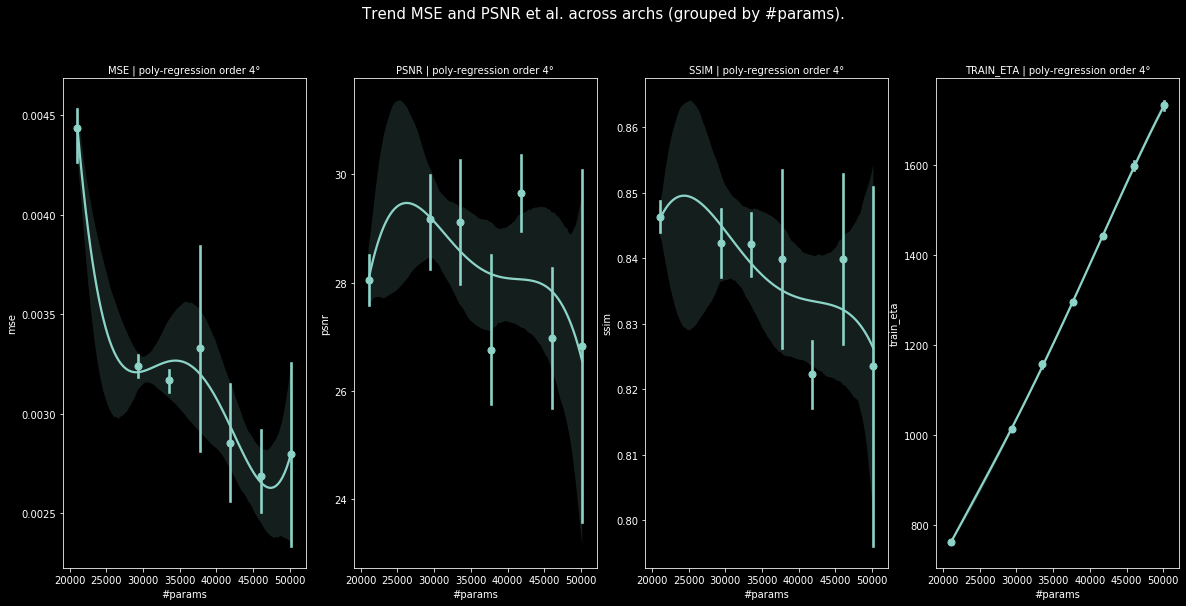

In [23]:
results_history_sorted_df = results_history_df.sort_values(by=['#params', 'hf', 'hl'])

grid_shape = "(1, 4)" #@param ["(1, 4)", "(4, 1)", "(2, 2)"]
grid_shape = eval(grid_shape)

fig, axes = None, None
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig, axes = graphics_regplot_mean_std(
        dataframe = results_history_sorted_df,
        y_axes = ("mse", "psnr", "ssim", "train_eta"),
        x_axis = "#params",
        grid_shape = grid_shape,
        figsize = (20, 10))
    pass
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"regplot_mse_psnr_et_al_grouped_by_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.regplot}")
plt.subplots_adjust(bottom = 0.2)
plt.show()

### Summary Graph

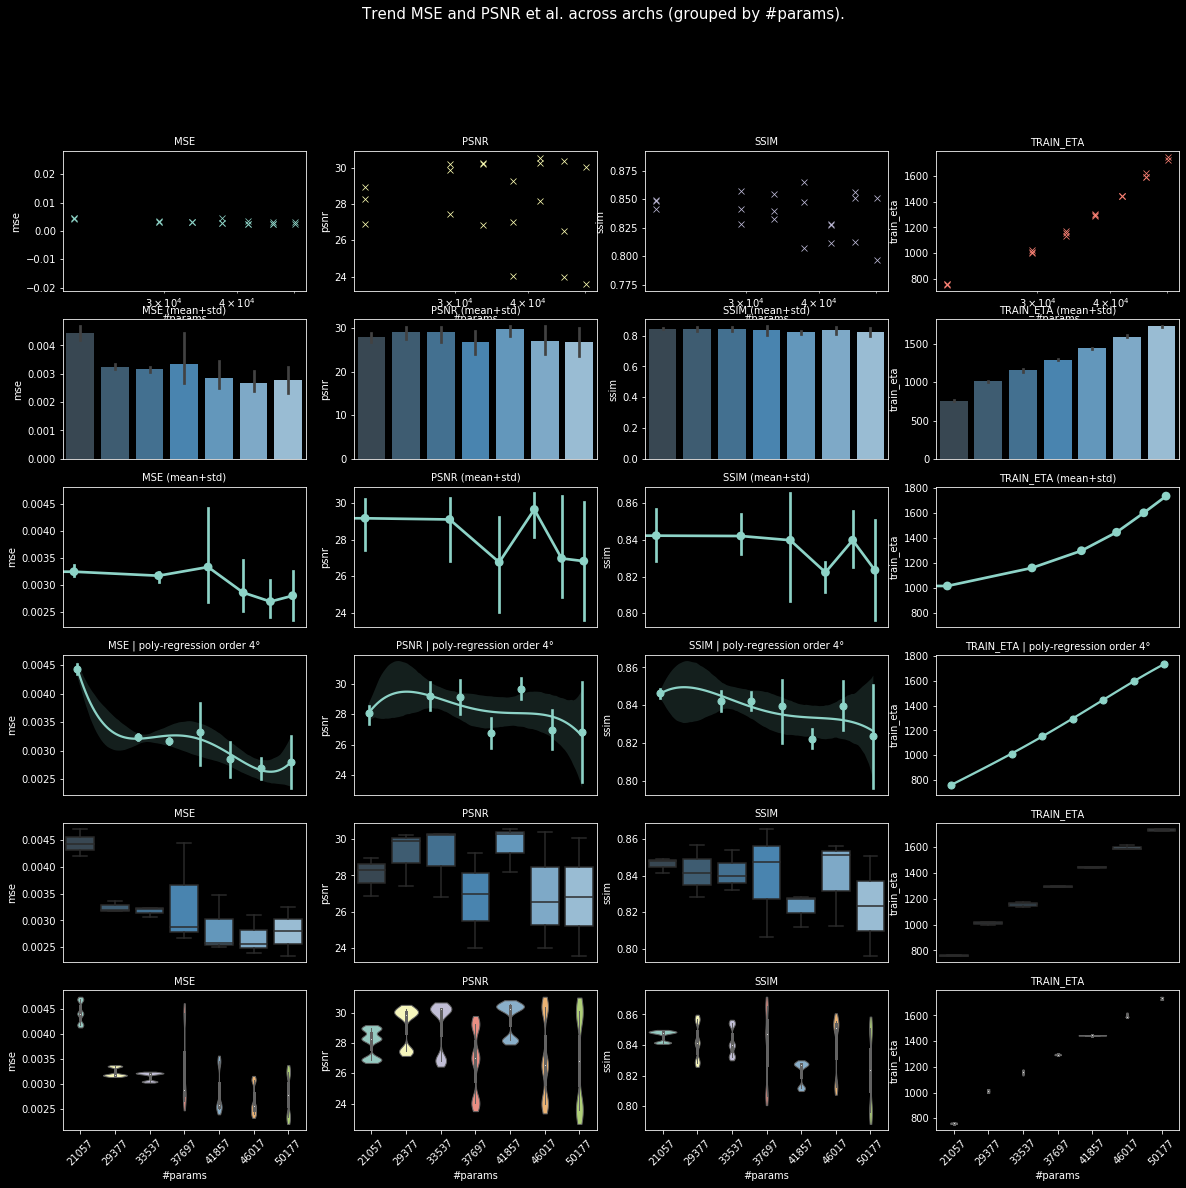

In [24]:
fig, axes = None, None
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig, axes = graphics_bars_pointplot(
        dataframe = results_history_sorted_df,
        y_axes = ("mse", "psnr", "ssim", "train_eta"),
        x_axis = "#params",
        grid_shape = (6, 4),
        figsize = (20, 20), palette="Blues_d",
        show_fig = False,
        title = 'Complex Plot')
    pass
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"complex_mse_psnr_et_al_grouped_by_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.complexplot}")
plt.subplots_adjust(bottom = 0.2)
# plt.tight_layout()
plt.show()

### Download files

In [25]:
print(f"Pictures ({len(list(Path(basedir_path_out_images).glob('*.png')))}):")
for path in Path(basedir_path_out_images).glob('*.png'):
    target_file = os.path.join(basedir_path_out_images, path.name)
    print(f"{target_file}")
    if in_colab() and download_pictures_checkbox:
        files.download(target_file)
    pass

Pictures (9):
mixed_out_train_0\barplot_mse_psnr_et_al_vs_no_params_train_no_0.png
mixed_out_train_0\boxplot_mse_psnr_et_al_vs_no_params_train_no_0.png
mixed_out_train_0\complexplot_mse_psnr_et_al_vs_no_params_train_no_0.png
mixed_out_train_0\df_jpeg_scatterplot_mse_psnr_et_al_vs_no_params_train_no_0.png
mixed_out_train_0\df_scatterplot_mse_psnr_et_al_vs_no_params_train_no_0.png
mixed_out_train_0\pointplot_mse_psnr_et_al_vs_no_params_train_no_0.png
mixed_out_train_0\regplot_mse_psnr_et_al_vs_no_params_train_no_0.png
mixed_out_train_0\scatterplot_mse_psnr_et_al_vs_no_params_train_no_0.png
mixed_out_train_0\violinplot_mse_psnr_et_al_vs_no_params_train_no_0.png


### Compare obtained results between JPEG and Siren

Image size: (481, 321)


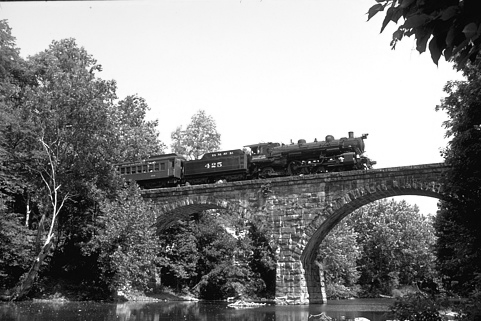

In [26]:
# Load target image.
image_file_path = 'test068.png'
im = Image.open(f'{image_file_path}')
print('Image size:', im.size)
im

(321, 321)


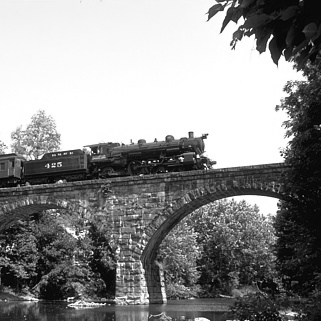

In [27]:
# Test how to manually crop image from left side.

width, height = im.size 

left = width - height
top = 0
right = width
bottom = height

print(im.crop((left, top, right, bottom)).size)
im.crop((left, top, right, bottom))

(321, 321)
(79, 0, 400, 321)


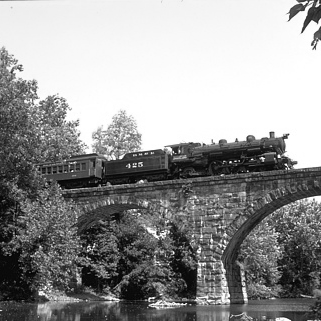

In [28]:
width, height = im.size 

left = width // 2 - height // 2 - 1
top = 0
right = width // 2 + height // 2
bottom = height

print(im.crop((left, top, right, bottom)).size)
print((left, top, right, bottom))
im.crop((left, top, right, bottom))

In [29]:
# Array of qualities to be tested in compression.
qualities_arr = np.arange(20, 95+1, dtype = np.int)

In [30]:
# Run several trials for JPEG compression.

cropped_file_size_bits = None
# im_cropped = im.crop((left, top, right, bottom))
# im_cropped = get_cropped_by_center_image(im, target = min(im.size))
im_cropped = im
with BytesIO() as f:
    im_cropped.save(f, format='PNG')
    cropped_file_size_bits = f.getbuffer().nbytes * 8
    pass

result_tuples, failure_qualities = \
  calculate_several_jpeg_compression(im_cropped, cropped_file_size_bits, qualities_arr)

In [31]:
# data = list(map(lambda xx: xx._asdict(), result_tuples))
data = list(map(methodcaller('_asdict'), result_tuples))
result_df = pd.DataFrame(data = data)
result_df.head(5)

,psnr,quality,file_size_bits,bpp,width,heigth,CR
0,25.124950,20,112536,0.728855,481,321,7.113599
1,25.273489,21,116224,0.752741,481,321,6.887872
2,25.398455,22,119760,0.775643,481,321,6.684502
3,25.533288,23,123512,0.799943,481,321,6.481443
4,25.655912,24,126704,0.820616,481,321,6.318159


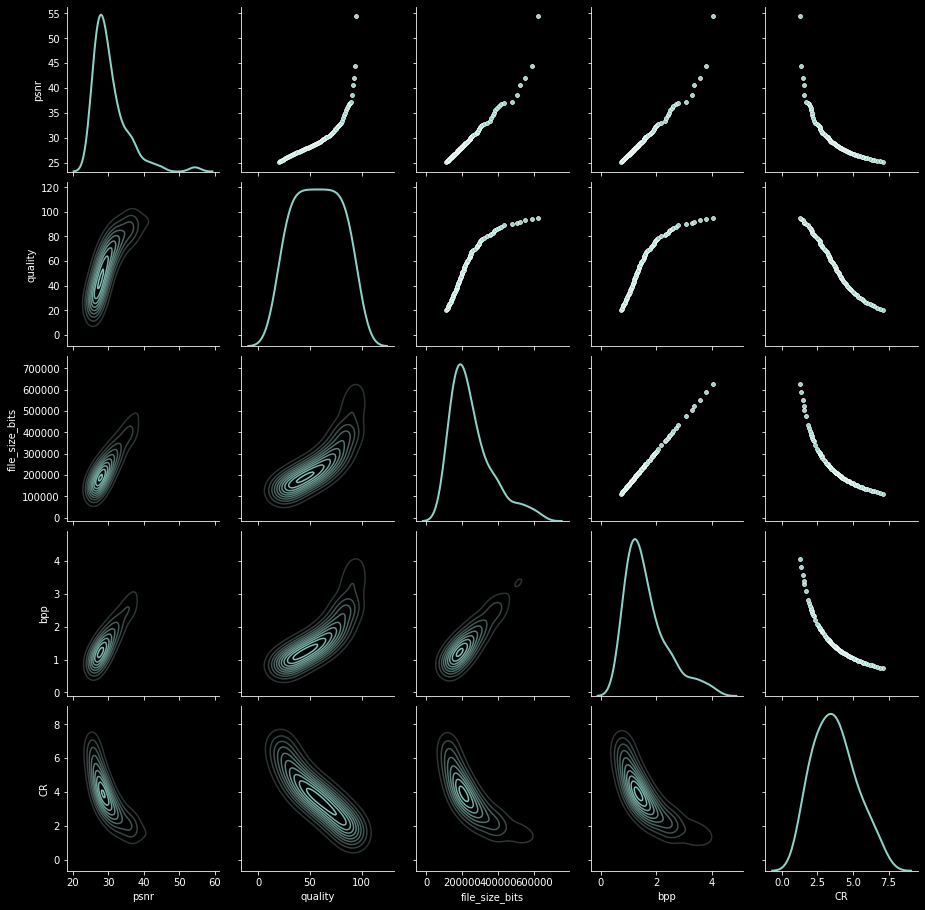

In [32]:
# sns.pairplot(results_history_df)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    try:
        g = sns.PairGrid(result_df.drop(['width', 'heigth'], axis = 1), diag_sharey=False)
        g.map_upper(sns.scatterplot, s=15) # 
        g.map_lower(sns.kdeplot)
        g.map_diag(sns.kdeplot, lw=2)
        plt.savefig(f"{images_conf.df_jpeg_scatterplot}")
    except Exception as err:
        print(str(err))
        pass
    pass

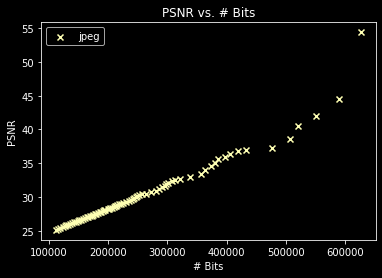

In [33]:
# Show calculated PSNR vs. # Bits.

# Prepare Data.
# x = np.arange(0, len(result_tuples), dtype=np.int)
x = np.array(list(map(lambda item: getattr(item, "file_size_bits"), result_tuples)))
y = np.array(list(map(lambda item: getattr(item, "psnr"), result_tuples)))

# Show plot.
fig = plt.figure()
plt.scatter(x, y, marker = 'x', color = sns.color_palette()[1], label = 'jpeg')
# plt.xscale('log')
plt.ylabel('PSNR')
plt.xlabel('# Bits')
plt.legend()
plt.title('PSNR vs. # Bits')
plt.show()

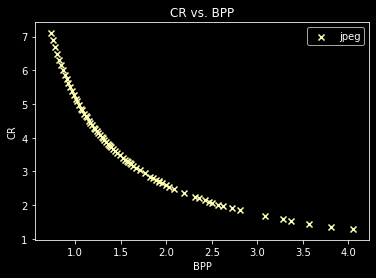

In [34]:
# Show calculated CR vs. # BPP.

# x = np.arange(0, len(result_tuples), dtype=np.int)
x = np.array(list(map(lambda item: getattr(item, "bpp"), result_tuples)))
y = np.array(list(map(lambda item: getattr(item, "CR"), result_tuples)))

fig = plt.figure()
plt.scatter(x, y, marker = 'x', color = sns.color_palette()[1], label = 'jpeg')
# plt.xscale('log')
plt.ylabel('CR')
plt.xlabel('BPP')
plt.legend()
plt.title('CR vs. BPP')
plt.show()

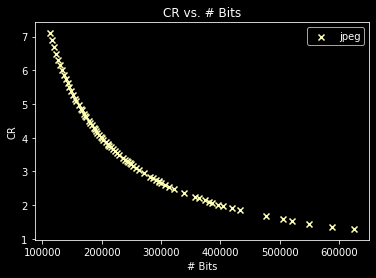

In [35]:
# Show calculated CR vs. # Bits.

# Prepare data.
# x = np.arange(0, len(result_tuples), dtype=np.int)
x = np.array(list(map(lambda item: getattr(item, "file_size_bits"), result_tuples)))
y = np.array(list(map(lambda item: getattr(item, "CR"), result_tuples)))

fig = plt.figure()
plt.scatter(x, y, marker = 'x', color = sns.color_palette()[1], label = 'jpeg')
# plt.xscale('log')
plt.ylabel('CR')
plt.xlabel('# Bits')
plt.legend()
plt.title('CR vs. # Bits')
plt.show()

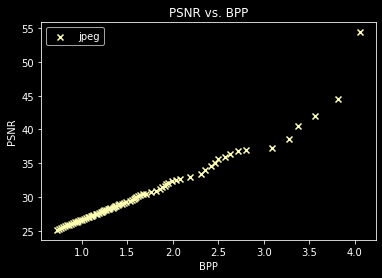

In [36]:
# Show calculated PSNR vs. Bits.

# Prepare Data
# x = np.arange(0, len(result_tuples), dtype=np.int)
x = np.array(list(map(lambda item: getattr(item, "bpp"), result_tuples)))
y = np.array(list(map(lambda item: getattr(item, "psnr"), result_tuples)))

# Show Plot
fig = plt.figure()
plt.scatter(x, y, marker = 'x', color = sns.color_palette()[1], label = 'jpeg')
# plt.xscale('log')
plt.ylabel('PSNR')
plt.xlabel('BPP')
plt.legend()
plt.title('PSNR vs. BPP')
plt.show()

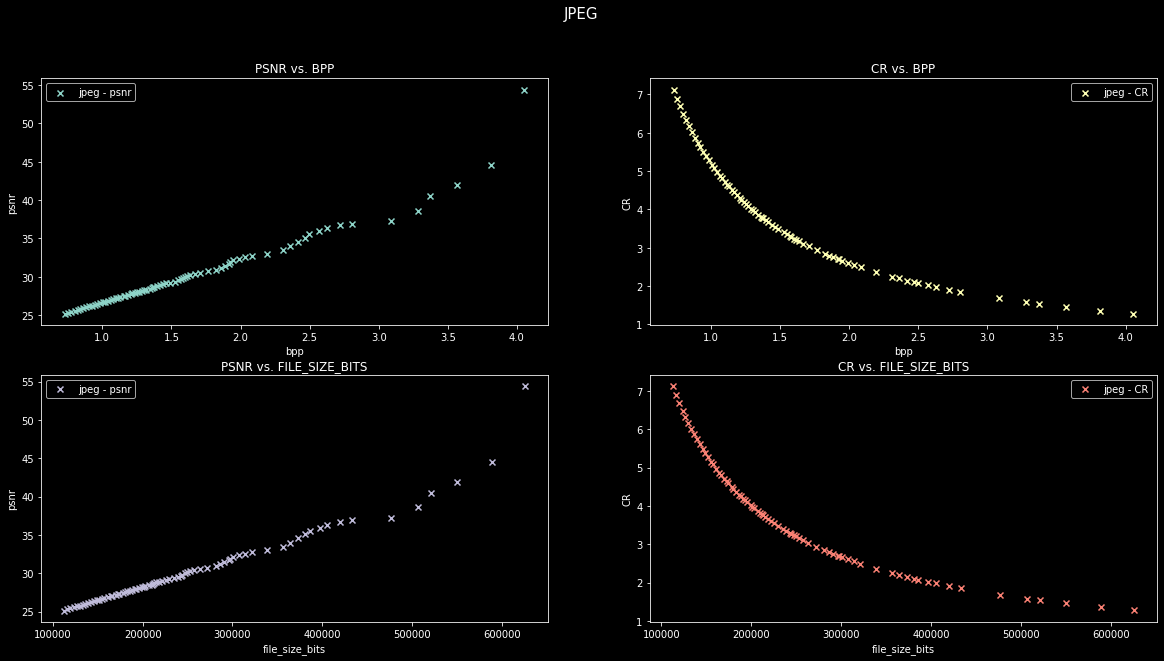

In [37]:
x_axes = "bpp;file_size_bits".split(";")
y_axes = "psnr;CR".split(";")

fig, axes = compute_graph_image_psnr_CR(
    data_tuples = result_tuples,
    x_axes = x_axes,
    y_axes = y_axes,
    subject = 'jpeg',
    colors = sns.color_palette())
fig.suptitle(f'JPEG', fontsize=15)
# plt.savefig('complex_plot_jpge_res.png')
plt.show()

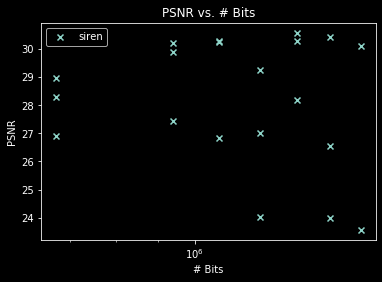

In [38]:
# Compare PSNR values between JPEG and Siren, by means of scatterplot.
fig = plt.figure()

# Siren results
# plt.scatter(x = np.arange(len(results_history_sorted_df['psnr'].values)), y = results_history_sorted_df['psnr'].values, marker = 'x', color = sns.color_palette()[0], label = 'siren output')
plt.scatter(x = results_history_sorted_df['#params'].values * 32,
    y = results_history_sorted_df['psnr'].values,
    marker = 'x',
    color = sns.color_palette()[0],
    label = 'siren')

# Jpeg results
"""
x = np.array(list(map(lambda item: getattr(item, "file_size_bits"), result_tuples)))
y = np.array(list(map(lambda item: getattr(item, "psnr"), result_tuples)))
plt.scatter(x, y, marker = 'x', color = sns.color_palette()[1], label = 'jpeg')
"""

plt.xscale('log')
plt.ylabel('PSNR')
plt.xlabel('# Bits')
plt.legend()
plt.title('PSNR vs. # Bits')
plt.show()

In [39]:
if (in_notebook() or in_ipython()) and show_visdom_results:
    vis = visdom.Visdom()

    x = list(results_history_sorted_df['#params'].values * 32)
    y = list(results_history_sorted_df['psnr'].values)
    trace = dict(x=x, y=y, mode="markers", type='custom',
             marker={'color': 'red', 'symbol': 104, 'size': "10"},
             # text=["one", "two", "three"],
             name='1st Trace')
    layout = dict(title="PSNR vs. # Bits", xaxis={'title': '#params'}, yaxis={'title': 'psnr'})

    vis._send({'data': [trace], 'layout': layout, 'win': 'psnr_vs_model_size'})
    
    vis.scatter(
        X=np.stack((x, y), axis = -1),
        # Y=(np.random.rand(255) + 1.5).astype(int),
        opts=dict(
            markersize=10,
            markersymbol='x',
            # markercolor=np.random.randint(0, 255, (2, 3,)),
        ),
    )
    pass

## Theory

### Bit Per Pixels (BPP)
-  computed as follows: $BPP = \frac{FILE\_SIZE_{image}}{\text{#} PIXELS_{image}} = \frac{FILE\_SIZE_{image}}{WIDHT_{image} \cdot EIGHT_{image}} $

### Compression Ratio (CR)
- computed as follows = $CR = \frac{UNCOMPRESSED\_IMAGE\_SIZE}{COMPRESSED\_IMAGE\_SIZE}$

## References

- Wiki references:
 - [Image Compression](https://en.m.wikipedia.org/wiki/Image_compression)
 - [Bit Rate](https://en.wikipedia.org/wiki/Bit_rate)

- Generic references:
 - [FORM](https://colab.research.google.com/notebooks/forms.ipynb#scrollTo=3jKM6GfzlgpS)
 - [jupiter - themese](https://stackoverflow.com/questions/46510192/change-the-theme-in-jupyter-notebook)

- skimage references:
  - [Module: metrics](https://scikit-image.org/docs/dev/api/skimage.metrics.html#module-skimage.metrics)

- Seaborn references:
  - [seaborn.PairGrid](https://seaborn.pydata.org/generated/seaborn.PairGrid.html)
  
- Python std lib references:
  - ... []()